In [1]:
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

"""
Majority rule consensus calling from a list of sequences.
Tweaked from Johannes's APARENT code:
https://github.com/johli/aparent/blob/2156b2826e0afcc21a8c8dc041c38364d1008cd3/data/random_mpra/individual_library/doubledope/unprocessed_data/doubledope_dna_processing.ipynb
"""
def call_consensus_sequence(fullseq_count_dict):
    # Assuming all sequences are the same length
    len_sequence = max([len(s) for s in fullseq_count_dict.keys()])
    bp_map = np.zeros((len_sequence, 4))
    total_count = 0
    for sequence, count in fullseq_count_dict.items():
        total_count += count
        for j in range(0, len(sequence)) :
            if sequence[j] == 'A' :
                bp_map[j, 0] += count
            elif sequence[j] == 'C' :
                bp_map[j, 1] += count
            elif sequence[j] == 'G' :
                bp_map[j, 2] += count
            elif sequence[j] == 'T' :
                bp_map[j, 3] += count

    consensus_sequence = ''
    for j in range(0, len_sequence) :
        max_i = int(np.argmax(bp_map[j, :]))
        # exclude positions that don't have at least 25% of the counts
        if bp_map[j, max_i] < total_count/4.:
            continue
        if max_i == 0 :
            consensus_sequence += 'A'
        elif max_i == 1 :
            consensus_sequence += 'C'
        elif max_i == 2 :
            consensus_sequence += 'G'
        elif max_i == 3 :
            consensus_sequence += 'T'
    
    return consensus_sequence


"""
Create directory, also taken from R2D2
"""
def create_directory(directory):
    """
        Create the output directory if it does not already exist.
        Return: The name of the directory.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

In [2]:
SVLst_input_output_dir = "/JTE-607_L3/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/"
SVLst_input_output_path_prefix = SVLst_input_output_dir + "SVLst_input"

parsed_SVLst_cleaved_output_dir = "/JTE-607_L3/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_SVLst_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/"
parsed_SVLst_DMSO_cleaved_csv = parsed_SVLst_cleaved_output_dir + "SVLst_DMSO_RNA_mapped_hammingsearch1_all_with_barcode.csv"
parsed_SVLst_0p5uM_cleaved_csv = parsed_SVLst_cleaved_output_dir + "SVLst_0p5uM_RNA_mapped_hammingsearch1_all_with_barcode.csv"
parsed_SVLst_2p5uM_cleaved_csv = parsed_SVLst_cleaved_output_dir + "SVLst_2p5uM_RNA_mapped_hammingsearch1_all_with_barcode.csv"
parsed_SVLst_12p5uM_cleaved_csv = parsed_SVLst_cleaved_output_dir + "SVLst_12p5uM_RNA_mapped_hammingsearch1_all_with_barcode.csv"

parsed_SVLst_cleaved_csv_dict = {"SVLst_DMSO": parsed_SVLst_DMSO_cleaved_csv,\
              "SVLst_0p5uM": parsed_SVLst_0p5uM_cleaved_csv,\
             "SVLst_2p5uM": parsed_SVLst_2p5uM_cleaved_csv,\
              "SVLst_12p5uM": parsed_SVLst_12p5uM_cleaved_csv}

Starting counts of previously culled visible barcodes: 
2111333
Parsing starcode clusters after culling
SVLst_DMSO
polyA_fail_count =  53234
N_in_read_count =  1375208
dinuc_fail_count =  8844


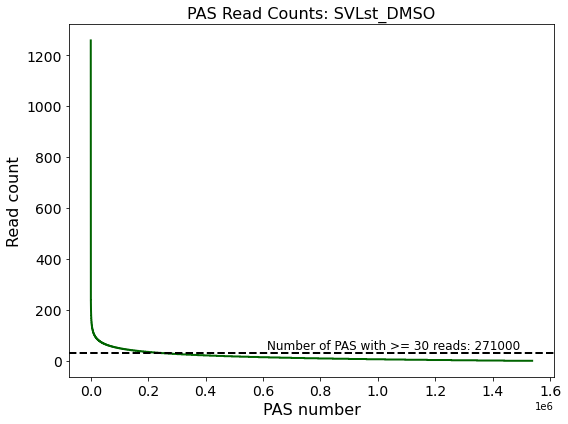

Number of PAS with >= 30 reads: 271000


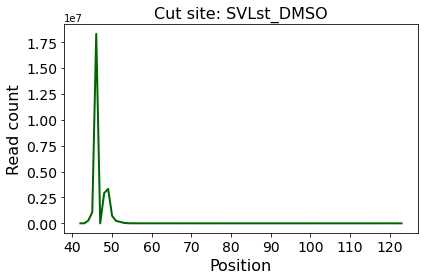

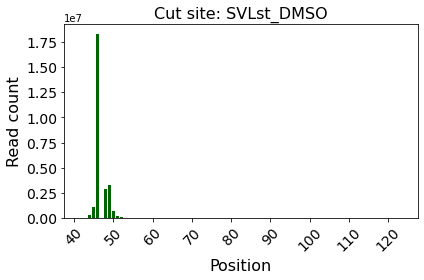

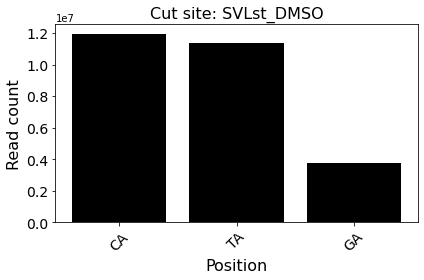

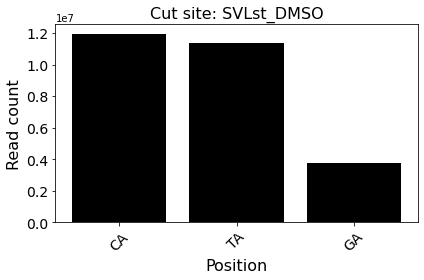

SVLst_0p5uM
polyA_fail_count =  28556
N_in_read_count =  729212
dinuc_fail_count =  4525


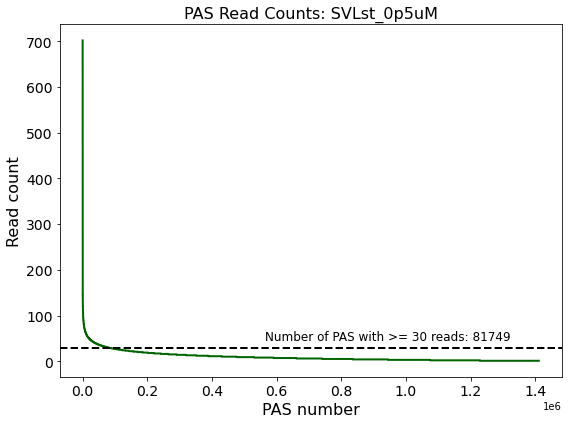

Number of PAS with >= 30 reads: 81749


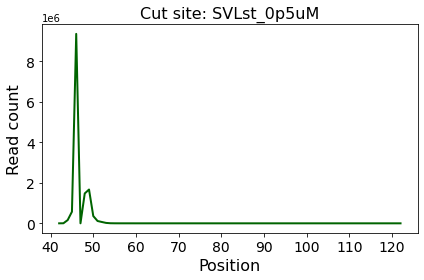

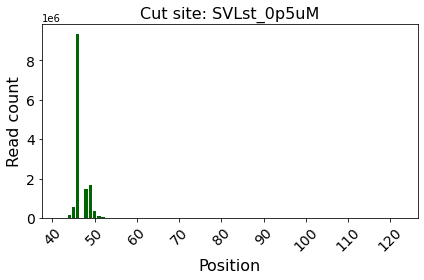

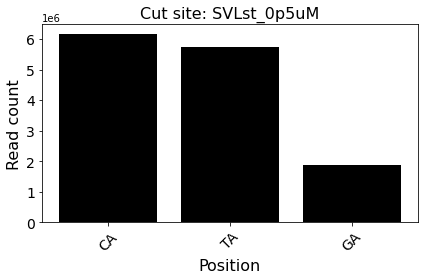

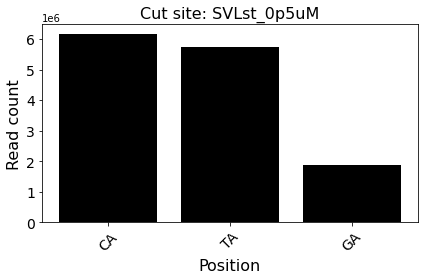

SVLst_2p5uM
polyA_fail_count =  34726
N_in_read_count =  727625
dinuc_fail_count =  5284


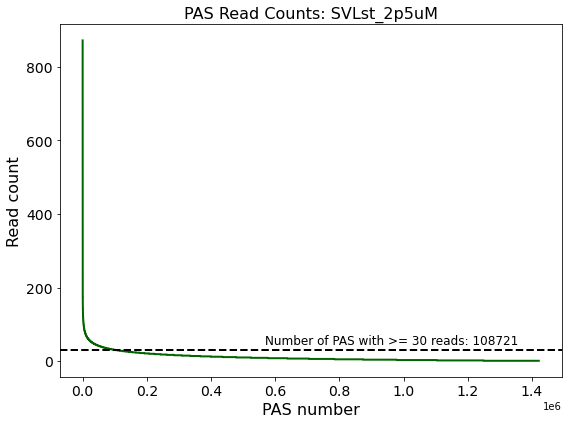

Number of PAS with >= 30 reads: 108721


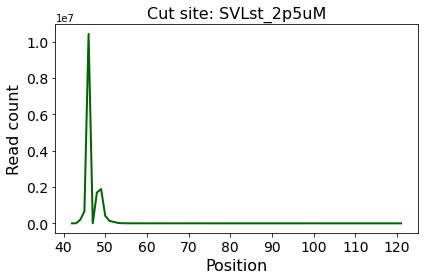

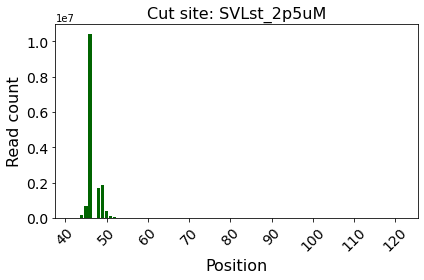

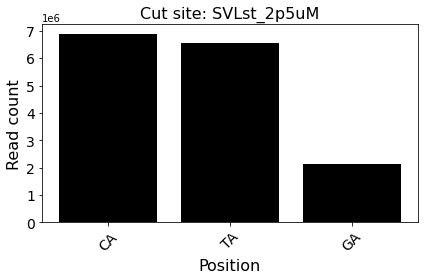

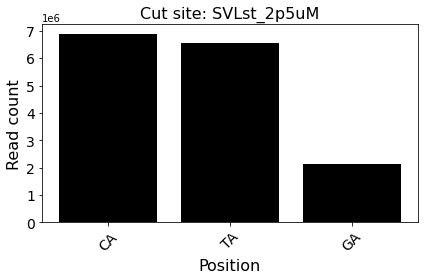

SVLst_12p5uM
polyA_fail_count =  31553
N_in_read_count =  720145
dinuc_fail_count =  4555


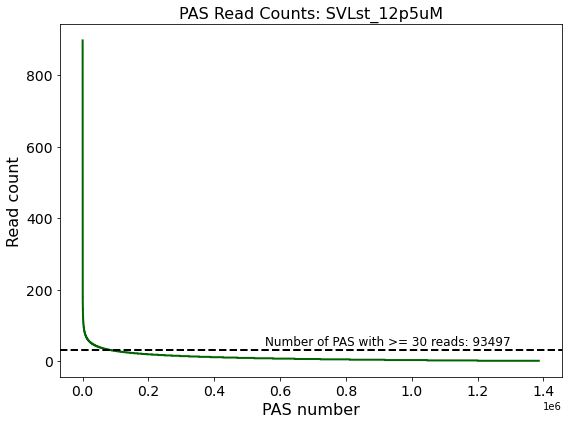

Number of PAS with >= 30 reads: 93497


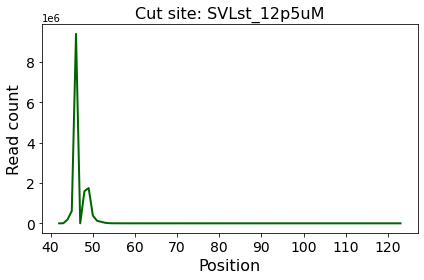

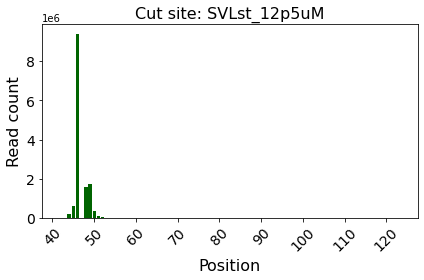

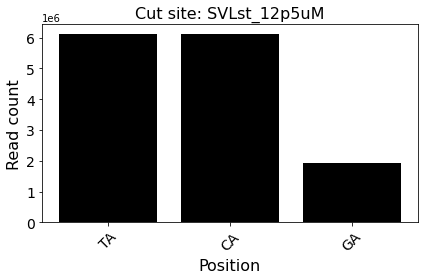

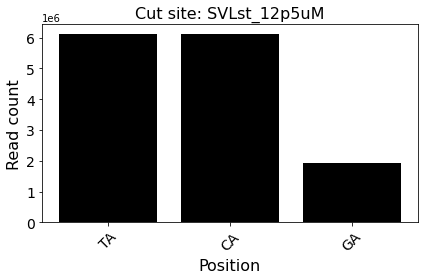

In [3]:
# load visible barcodes dictionary
visible_barcodes_dict = dict(pickle.load(open(SVLst_input_output_path_prefix + '_visible_barcodes_culled.pickle', 'rb')))
print("Starting counts of previously culled visible barcodes: ")
print(len(visible_barcodes_dict))

# parse SVLst cleaved libraries
SVLst_5p_shared = "TGCTTTATTTGTAACCATTATAAGCTGCAATAAA"
SVLst_3p_shared = "ATTTTATGTTTCAGGTTCAGGGGGAGGTGTGGGAGGTTTTTTAAAGCAAGTAGAATTCGAT"
output_dir = create_directory(parsed_SVLst_cleaved_output_dir + "collapsed/")

print("Parsing starcode clusters after culling")

for data_name, csv_file in parsed_SVLst_cleaved_csv_dict.items():
    print(data_name)
    output_prefix = output_dir + data_name
    polya_pos_dict = defaultdict(dict)  # barcode_cluster -> {polyA_pos: count}
    dinuc_cleave_read_dict = defaultdict(dict)  # barcode_cluster -> {dinuc_cleave_read: count}
    dinuc_cleave_expected_dict = defaultdict(dict)  # barcode_cluster -> {dinuc_cleave_exp: count}
    line_count = 0
    polyA_fail_count = 0
    N_in_read_count = 0
    dinuc_fail_count = 0
    with open(csv_file, "r") as f:
        with open(output_prefix + "_RNA_mapped_removeBadPolyA.csv", "w") as out:
            for line in f:
                line_count += 1
                if line_count == 1:
                    out.write(line)
                    continue

                curr_barcode, curr_rna_read, _, _, curr_align_start, _, curr_polya_pos, _ = line.strip().split(",")
                curr_align_start = int(curr_align_start)

                if len(visible_barcodes_dict[curr_barcode].keys()) > 1:
                    print("Need to remove multi-mapping visible barcodes!")
                    sys.exit()  # probably should change to exception eventually

                full_barcode_cluster = curr_barcode + list(visible_barcodes_dict[curr_barcode].keys())[0]
                curr_PAS = full_barcode_cluster
                curr_polya_pos = int(curr_polya_pos)
                
                # check for N's in RNA-seq
                if "N" in curr_rna_read:
                    N_in_read_count += 1

                # check for weird polyA position calling, will ignore these because means barcode cluster didn't match
                # allowing up to 10% mismatches
                polyA_tail_check = curr_rna_read[curr_polya_pos + curr_align_start:].count("A") < round(len(curr_rna_read[curr_polya_pos + curr_align_start:]) * 0.9)
                if polyA_tail_check or curr_polya_pos < 34:
                    polyA_fail_count += 1
                    continue
                
                # Need to account for N4 b/c curr_polya_pos does not have N4.
                dinuc_cleave_read = curr_rna_read[(curr_polya_pos + curr_align_start - 1):(curr_polya_pos + curr_align_start + 1)]
                if len(dinuc_cleave_read) != 2:
                    dinuc_fail_count += 1
                    continue
                elif "N" in dinuc_cleave_read:
                    # Do not allow cut sites with "N"
                    dinuc_fail_count += 1
                    continue
                
                # passed checks so write out
                out.write(line)
                
                if curr_polya_pos not in polya_pos_dict[curr_PAS]:
                    polya_pos_dict[curr_PAS][curr_polya_pos] = 1
                else:
                    polya_pos_dict[curr_PAS][curr_polya_pos] += 1

                if dinuc_cleave_read not in dinuc_cleave_read_dict[curr_PAS]:
                    dinuc_cleave_read_dict[curr_PAS][dinuc_cleave_read] = 1
                else:
                    dinuc_cleave_read_dict[curr_PAS][dinuc_cleave_read] += 1

                expected_read = SVLst_5p_shared + full_barcode_cluster + SVLst_3p_shared
                dinuc_cleave_exp = curr_rna_read[(curr_polya_pos + curr_align_start - 1):(curr_polya_pos + curr_align_start + 1)]
                if dinuc_cleave_exp not in dinuc_cleave_expected_dict[curr_PAS]:
                    dinuc_cleave_expected_dict[curr_PAS][dinuc_cleave_exp] = 1
                else:
                    dinuc_cleave_expected_dict[curr_PAS][dinuc_cleave_exp] += 1
    
    print("polyA_fail_count = ", polyA_fail_count)
    print("N_in_read_count = ", N_in_read_count)
    print("dinuc_fail_count = ", dinuc_fail_count)
    
    # Save polya_pos_dict, dinuc_cleave_read_dict, dinuc_cleave_expected_dict
    pickle.dump(polya_pos_dict, open(output_prefix + '_polya_pos_dict.pickle', 'wb'))
    pickle.dump(dinuc_cleave_read_dict, open(output_prefix + '_dinuc_cleave_read_dict.pickle', 'wb'))
    pickle.dump(dinuc_cleave_expected_dict, open(output_prefix + '_dinuc_cleave_expected_dict.pickle', 'wb'))

    # Printing out PAS read counts
    PAS_read_counts = defaultdict(int)
    with open(output_prefix + "_PAS_read_counts.txt", "w") as f:
        for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
            curr_total_reads = sum(curr_polya_pos_count_dict.values())
            f.write("%s\t%s\n" % (curr_PAS, curr_total_reads))
            PAS_read_counts[curr_PAS] += curr_total_reads
    
    # Printing out polyA position info
    polyA_pos_counts = defaultdict(int)
    with open(output_prefix + "_polya_pos.txt", "w") as f:
        for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
            for curr_polya_pos, count in curr_polya_pos_count_dict.items():
                f.write("%s\t%s\t%s\n" % (curr_PAS, curr_polya_pos, count))
                polyA_pos_counts[curr_polya_pos] += count
    
    with open(output_prefix + "_polya_pos_aggregated.txt", "w") as f:
        f.write("\n".join(["\t".join([str(p), str(c)]) for p, c in sorted(polyA_pos_counts.items())]) + "\n")
    
    # Printing out dinucleotide cleavage usage
    dinuc_cleave_read_counts = defaultdict(int)
    with open(output_prefix + "_dinuc_cleave_read_counts.txt", "w") as f:
        for curr_PAS, curr_dinuc_cleave_read_dict in dinuc_cleave_read_dict.items():
            for curr_dinuc_cleave_read, count in curr_dinuc_cleave_read_dict.items():
                f.write("%s\t%s\t%s\n" % (curr_PAS, curr_dinuc_cleave_read, count))
                dinuc_cleave_read_counts[curr_dinuc_cleave_read] += count
    
    with open(output_prefix + "_dinuc_cleave_read_aggregated.txt", "w") as f:
        f.write("\n".join(["\t".join([str(p), str(c)]) for p, c in sorted(dinuc_cleave_read_counts.items())]) + "\n")
    
    dinuc_cleave_exp_counts = defaultdict(int)
    with open(output_prefix + "_dinuc_cleave_expected_counts.txt", "w") as f:
        for curr_PAS, curr_dinuc_cleave_exp_dict in dinuc_cleave_expected_dict.items():
            for curr_dinuc_cleave_exp, count in curr_dinuc_cleave_exp_dict.items():
                f.write("%s\t%s\t%s\n" % (curr_PAS, curr_dinuc_cleave_exp, count))
                dinuc_cleave_exp_counts[curr_dinuc_cleave_exp] += count
    
    with open(output_prefix + "_dinuc_cleave_expected_aggregated.txt", "w") as f:
        f.write("\n".join(["\t".join([str(p), str(c)]) for p, c in sorted(dinuc_cleave_exp_counts.items())]) + "\n")
    
    f = plt.figure(figsize=(8, 6))

    # plot PAS read counts
    y = sorted(PAS_read_counts.values(), reverse=True)
    plt.plot(np.arange(len(y)), y, c='darkgreen', linewidth=2)
    plt.axhline(y=30, linewidth=2, c='black', linestyle='--')
    plt.text(len(y)/2.5, 45, "Number of PAS with >= 30 reads: " + str(len([i for i in y if i >= 30])), fontsize=12)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('PAS number', fontsize=16)
    plt.ylabel('Read count', fontsize=16)
    plt.title('PAS Read Counts: ' + data_name, fontsize=16)
    plt.tight_layout()

    plt.savefig(output_prefix + "_PAS_read_counts.tiff")
    plt.show()

    print("Number of PAS with >= 30 reads: " + str(len([i for i in y if i >= 30])))

    # plot polyA positions
    x, y = zip(*sorted(polyA_pos_counts.items()))
    plt.plot(x, y, c='darkgreen', linewidth=2)
    #plt.axvline(x=50, linewidth=2, c='black', linestyle='--')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Position', fontsize=16)
    plt.ylabel('Read count', fontsize=16)
    plt.title('Cut site: ' + data_name, fontsize=16)
    plt.tight_layout()

    plt.savefig(output_prefix + "_cut_sites.tiff")
    plt.show()
    
    plt.bar(x, y, color='darkgreen')
    #plt.axvline(x=50, linewidth=2, c='black', linestyle='--')

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.xlabel('Position', fontsize=16)
    plt.ylabel('Read count', fontsize=16)
    plt.title('Cut site: ' + data_name, fontsize=16)
    plt.tight_layout()

    plt.savefig(output_prefix + "_cut_sites_bar.tiff")
    plt.show()


    # plot dinucleotide reads usage
    x, y = zip(*sorted(dinuc_cleave_read_counts.items(), key=lambda x: x[1], reverse=True))
    plt.bar(x, y, color='black')

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.xlabel('Position', fontsize=16)
    plt.ylabel('Read count', fontsize=16)
    plt.title('Cut site: ' + data_name, fontsize=16)
    plt.tight_layout()

    plt.savefig(output_prefix + "_dinuc_cleave_read_counts.tiff")
    plt.show()


    # plot dinucleotide expected usage
    x, y = zip(*sorted(dinuc_cleave_exp_counts.items(), key=lambda x: x[1], reverse=True))
    plt.bar(x, y, color='black')

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.xlabel('Position', fontsize=16)
    plt.ylabel('Read count', fontsize=16)
    plt.title('Cut site: ' + data_name, fontsize=16)
    plt.tight_layout()

    plt.savefig(output_prefix + "_dinuc_cleave_expected_counts.tiff")
    plt.show()

55211
[12240, 4177, 17270, 95]
[9349, 20581, 13008, 110, 104, 689]


/home/ec2-user/anaconda3/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/ec2-user/anaconda3/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((


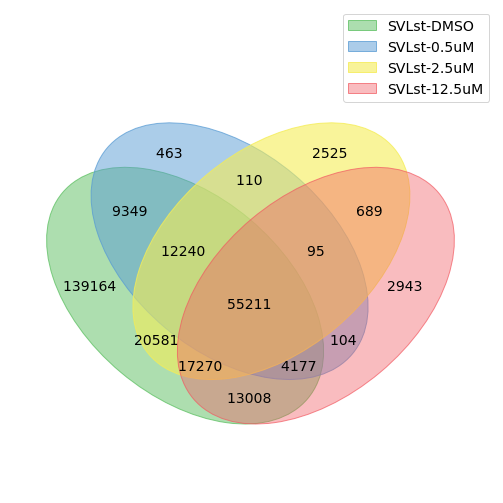

In [4]:
import venn

parsed_SVLst_cleaved_output_dir = output_dir
polyA_SVLst_DMSO_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_DMSO_polya_pos_dict.pickle"
polyA_SVLst_0p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_0p5uM_polya_pos_dict.pickle"
polyA_SVLst_2p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_2p5uM_polya_pos_dict.pickle"
polyA_SVLst_12p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_12p5uM_polya_pos_dict.pickle"

polyA_pos_pickle_dict = {"SVLst_DMSO": polyA_SVLst_DMSO_cleaved_pickle,\
              "SVLst_0p5uM": polyA_SVLst_0p5uM_cleaved_pickle,\
             "SVLst_2p5uM": polyA_SVLst_2p5uM_cleaved_pickle,\
              "SVLst_12p5uM": polyA_SVLst_12p5uM_cleaved_pickle}

PAS_mincov30 = {"SVLst_DMSO": [],\
              "SVLst_0p5uM": [],\
             "SVLst_2p5uM": [],\
              "SVLst_12p5uM": []}

for data_name, pickle_name in polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        curr_total_reads = sum(curr_polya_pos_count_dict.values())
        PAS_read_counts[curr_PAS] += curr_total_reads
    for curr_PAS, curr_count in list(PAS_read_counts.items()):
        if curr_count < 30:
            del PAS_read_counts[curr_PAS]
    PAS_mincov30[data_name] = set(PAS_read_counts.keys())

all_intersect = len(PAS_mincov30["SVLst_DMSO"].intersection(PAS_mincov30["SVLst_0p5uM"], PAS_mincov30["SVLst_2p5uM"], PAS_mincov30["SVLst_12p5uM"]))
print(all_intersect)
D_0_2_intersect = len(PAS_mincov30["SVLst_DMSO"].intersection(PAS_mincov30["SVLst_0p5uM"], PAS_mincov30["SVLst_2p5uM"])) - all_intersect
D_0_12_intersect = len(PAS_mincov30["SVLst_DMSO"].intersection(PAS_mincov30["SVLst_0p5uM"], PAS_mincov30["SVLst_12p5uM"])) - all_intersect
D_2_12_intersect = len(PAS_mincov30["SVLst_DMSO"].intersection(PAS_mincov30["SVLst_2p5uM"], PAS_mincov30["SVLst_12p5uM"])) - all_intersect
c0_2_12_intersect = len(PAS_mincov30["SVLst_0p5uM"].intersection(PAS_mincov30["SVLst_2p5uM"], PAS_mincov30["SVLst_12p5uM"])) - all_intersect
print([D_0_2_intersect, D_0_12_intersect, D_2_12_intersect, c0_2_12_intersect])

D_0_intersect = len(PAS_mincov30["SVLst_DMSO"].intersection(PAS_mincov30["SVLst_0p5uM"])) - D_0_2_intersect - D_0_12_intersect - all_intersect
D_2_intersect = len(PAS_mincov30["SVLst_DMSO"].intersection(PAS_mincov30["SVLst_2p5uM"])) - D_0_2_intersect - D_2_12_intersect - all_intersect
D_12_intersect = len(PAS_mincov30["SVLst_DMSO"].intersection(PAS_mincov30["SVLst_12p5uM"])) - D_0_12_intersect - D_2_12_intersect - all_intersect
c0_2_intersect = len(PAS_mincov30["SVLst_0p5uM"].intersection(PAS_mincov30["SVLst_2p5uM"])) - c0_2_12_intersect - D_0_2_intersect - all_intersect
c0_12_intersect = len(PAS_mincov30["SVLst_0p5uM"].intersection(PAS_mincov30["SVLst_12p5uM"])) - D_0_12_intersect - c0_2_12_intersect - all_intersect
c2_12_intersect = len(PAS_mincov30["SVLst_2p5uM"].intersection(PAS_mincov30["SVLst_12p5uM"])) - c0_2_12_intersect - D_2_12_intersect - all_intersect
print([D_0_intersect, D_2_intersect, D_12_intersect, c0_2_intersect, c0_12_intersect, c2_12_intersect])

labels = venn.get_labels([PAS_mincov30["SVLst_DMSO"], PAS_mincov30["SVLst_0p5uM"], PAS_mincov30["SVLst_2p5uM"], PAS_mincov30["SVLst_12p5uM"]], fill=['number'])
fig, ax = venn.venn4(labels, names=['SVLst-DMSO', 'SVLst-0.5uM', 'SVLst-2.5uM', 'SVLst-12.5uM'])
fig.savefig(parsed_SVLst_cleaved_output_dir + "PAS_mincov30_venn.tiff")

fig.show()


In [5]:
# Calculate representation of PAS's in each dataset
polyA_SVLst_DMSO_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_DMSO_polya_pos_dict.pickle"
polyA_SVLst_0p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_0p5uM_polya_pos_dict.pickle"
polyA_SVLst_2p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_2p5uM_polya_pos_dict.pickle"
polyA_SVLst_12p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_12p5uM_polya_pos_dict.pickle"

polyA_pos_pickle_dict = {"SVLst_DMSO": polyA_SVLst_DMSO_cleaved_pickle,\
              "SVLst_0p5uM": polyA_SVLst_0p5uM_cleaved_pickle,\
             "SVLst_2p5uM": polyA_SVLst_2p5uM_cleaved_pickle,\
              "SVLst_12p5uM": polyA_SVLst_12p5uM_cleaved_pickle}

PAS_read_counts = {"SVLst_DMSO": [],\
              "SVLst_0p5uM": [],\
             "SVLst_2p5uM": [],\
              "SVLst_12p5uM": []}

PAS_percents_dict = {"SVLst_DMSO": None,\
              "SVLst_0p5uM": None,\
             "SVLst_2p5uM": None,\
              "SVLst_12p5uM": None}

all_PAS = set()
for data_name, pickle_name in polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        curr_total_reads = sum(curr_polya_pos_count_dict.values())
        PAS_read_counts[curr_PAS] += curr_total_reads
        all_PAS.add(curr_PAS)
    total_reads = float(sum(PAS_read_counts.values()))  # float for division later
    percentage_dict = {curr_PAS:(curr_read_count/total_reads) for curr_PAS, curr_read_count in PAS_read_counts.items()}
    df = pd.DataFrame(list(percentage_dict.items()),columns = ['PAS', data_name + '_percent'])
    PAS_percents_dict[data_name] = df

print(len(all_PAS))

merged_PAS_percentage = None
for data_name, curr_df in PAS_percents_dict.items():
    if merged_PAS_percentage is None:
        merged_PAS_percentage = curr_df
    else:
        merged_PAS_percentage = merged_PAS_percentage.merge(curr_df, how='outer', on="PAS")
merged_PAS_percentage = merged_PAS_percentage.fillna(0)
print(merged_PAS_percentage.shape)

pickle.dump(merged_PAS_percentage, open(parsed_SVLst_cleaved_output_dir + 'SVLst_cleaved_merged_PAS_percentage.pickle', 'wb'))

1599396
(1599396, 5)


In [6]:
merged_PAS_percentage = pickle.load(open(parsed_SVLst_cleaved_output_dir + 'SVLst_cleaved_merged_PAS_percentage.pickle', 'rb'))

"""
# This takes too long to run in notebook
#plotting_df = merged_PAS_percentage.head(10)
#plotting_df = merged_PAS_percentage.head(100)
plotting_df = merged_PAS_percentage
plotting_df = plotting_df.drop(["PAS"], axis=1)
plot_df = plotting_df.T
print(plot_df)

f = plt.figure(figsize=(8, 6))
f.set_size_inches(18.5, 10.5, forward=True)

ax = plot_df.plot(figsize=(12, 10))
#type(ax)  # matplotlib.axes._subplots.AxesSubplot
ax.get_legend().remove()
f.savefig(parsed_L3_cleaved_output_dir + "PAS_percentages.tiff")

f.show()
"""

'\n# This takes too long to run in notebook\n#plotting_df = merged_PAS_percentage.head(10)\n#plotting_df = merged_PAS_percentage.head(100)\nplotting_df = merged_PAS_percentage\nplotting_df = plotting_df.drop(["PAS"], axis=1)\nplot_df = plotting_df.T\nprint(plot_df)\n\nf = plt.figure(figsize=(8, 6))\nf.set_size_inches(18.5, 10.5, forward=True)\n\nax = plot_df.plot(figsize=(12, 10))\n#type(ax)  # matplotlib.axes._subplots.AxesSubplot\nax.get_legend().remove()\nf.savefig(parsed_L3_cleaved_output_dir + "PAS_percentages.tiff")\n\nf.show()\n'

                 0.0           0.5           2.5           12.5
62       2.327495e-06  2.970385e-06  3.535226e-06  4.089721e-06
114      7.425817e-06  7.969325e-06  8.163158e-06  1.085891e-05
116      1.219164e-06  1.666313e-06  1.864028e-06  2.044861e-06
153      5.948043e-06  6.737702e-06  6.749068e-06  7.897393e-06
158      2.216662e-07  2.897936e-07  3.213842e-07  3.525622e-07
...               ...           ...           ...           ...
1570883  0.000000e+00  7.244841e-08  2.571073e-07  4.230746e-07
1570891  0.000000e+00  7.244841e-08  1.285537e-07  1.410249e-07
1570977  0.000000e+00  7.244841e-08  1.928305e-07  2.115373e-07
1571018  0.000000e+00  7.244841e-08  1.285537e-07  2.115373e-07
1571019  0.000000e+00  7.244841e-08  1.285537e-07  2.820497e-07

[54306 rows x 4 columns]
       62        114       116       153           158           165      \
0.0   0.000002  0.000007  0.000001  0.000006  2.216662e-07  7.758316e-07   
0.5   0.000003  0.000008  0.000002  0.000007  2.897936

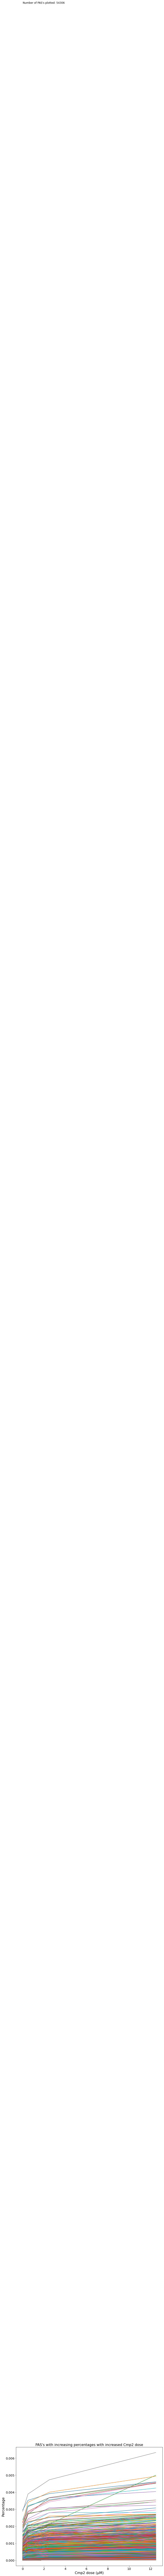

In [7]:
plotting_df = merged_PAS_percentage.drop(["PAS"], axis=1)

pos_df = plotting_df[(plotting_df["SVLst_DMSO_percent"] < plotting_df["SVLst_0p5uM_percent"])]
pos_df = pos_df[(pos_df["SVLst_0p5uM_percent"] < pos_df["SVLst_2p5uM_percent"])]
pos_df = pos_df[(pos_df["SVLst_2p5uM_percent"] < pos_df["SVLst_12p5uM_percent"])]
pos_df.columns = [0, 0.5, 2.5, 12.5]
pos_df_T = pos_df.T
print(pos_df)
print(pos_df_T)
pos_df_T_percentage = pos_df_T*100

ax = pos_df_T_percentage.plot(figsize=(12, 10))
#type(ax)  # matplotlib.axes._subplots.AxesSubplot
ax.ticklabel_format(style='plain')
ax.get_legend().remove()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Cmp2 dose (μM)', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title("PAS's with increasing percentages with increased Cmp2 dose", fontsize=16)
plt.text(0.01, 0.15, "Number of PAS's plotted: " + str(len(pos_df_T_percentage.columns)), fontsize=12)

plt.savefig(parsed_SVLst_cleaved_output_dir + "PAS_percentages_increasing.tiff")


                 0.0           0.5           2.5           12.5
17       1.847218e-06  1.738762e-06  1.028429e-06  4.935870e-07
24       1.551663e-06  1.086726e-06  8.998757e-07  8.461492e-07
44       5.541655e-07  4.346904e-07  3.856610e-07  2.115373e-07
56       1.366941e-06  7.969325e-07  3.856610e-07  2.115373e-07
64       4.433324e-07  2.173452e-07  1.928305e-07  7.051243e-08
...               ...           ...           ...           ...
1534975  1.108331e-07  7.244841e-08  6.427684e-08  0.000000e+00
1535155  7.388873e-08  7.244841e-08  6.427684e-08  0.000000e+00
1535226  7.388873e-08  7.244841e-08  6.427684e-08  0.000000e+00
1535628  7.388873e-08  7.244841e-08  6.427684e-08  0.000000e+00
1535815  1.477775e-07  1.448968e-07  1.285537e-07  0.000000e+00

[87553 rows x 4 columns]
           17            24            44            56            64       \
0.0   1.847218e-06  1.551663e-06  5.541655e-07  1.366941e-06  4.433324e-07   
0.5   1.738762e-06  1.086726e-06  4.346904e-07  7.

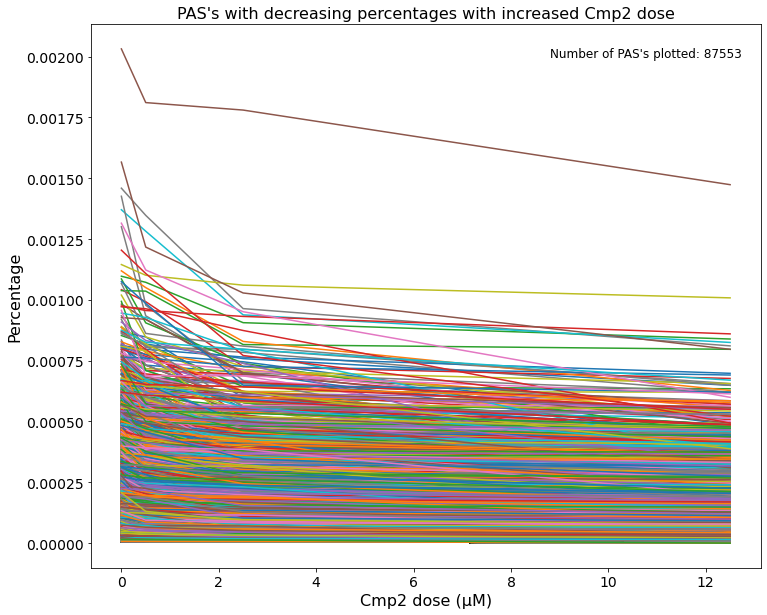

In [8]:
plotting_df = merged_PAS_percentage.drop(["PAS"], axis=1)

neg_df = plotting_df[(plotting_df["SVLst_DMSO_percent"] > plotting_df["SVLst_0p5uM_percent"])]
neg_df = neg_df[(neg_df["SVLst_0p5uM_percent"] > neg_df["SVLst_2p5uM_percent"])]
neg_df = neg_df[(neg_df["SVLst_2p5uM_percent"] > neg_df["SVLst_12p5uM_percent"])]
neg_df.columns = [0, 0.5, 2.5, 12.5]
neg_df_T = neg_df.T
print(neg_df)
print(neg_df_T)
neg_df_T_percentage = neg_df_T*100

ax = neg_df_T_percentage.plot(figsize=(12, 10))
#type(ax)  # matplotlib.axes._subplots.AxesSubplot
ax.ticklabel_format(style='plain')
ax.get_legend().remove()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Cmp2 dose (μM)', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title("PAS's with decreasing percentages with increased Cmp2 dose", fontsize=16)
plt.text(8.8, 0.002, "Number of PAS's plotted: " + str(len(neg_df_T_percentage.columns)), fontsize=12)

plt.savefig(parsed_SVLst_cleaved_output_dir + "PAS_percentages_decreasing.tiff")


['CACGTTGCGTTCATGTGTAGATATG', 'GAGACGTACGACAAGAGGAATGGCG', 'TCGTCTTCTGTCATGGGAAGTTGTG', 'CCGTGACTTTGCATCAGATCCGTTA', 'TGGAGTGAACGCATTGAGTGTCTAG', 'CTGTGAGAAGGCACCGAGCGCGTGG', 'GGCCGAATGAGTATACTGTCGCTTT', 'CACTCAACATACATAATGTGGTGCG', 'TATACGTCGAATAGACCTTGACTGC', 'CAGGTTGTTTTCATATCGGTTGGGC']
PAS   CACGTTGCGTTCATGTGTAGATATG  GAGACGTACGACAAGAGGAATGGCG  \
0.0                    0.000650                   0.000369   
0.5                    0.000413                   0.000377   
2.5                    0.000668                   0.000302   
12.5                   0.000472                   0.000360   

PAS   TCGTCTTCTGTCATGGGAAGTTGTG  CCGTGACTTTGCATCAGATCCGTTA  \
0.0                    0.000144                   0.000248   
0.5                    0.000254                   0.000304   
2.5                    0.000341                   0.000264   
12.5                   0.000303                   0.000346   

PAS   TGGAGTGAACGCATTGAGTGTCTAG  CTGTGAGAAGGCACCGAGCGCGTGG  \
0.0                    0.

<Figure size 1332x756 with 0 Axes>

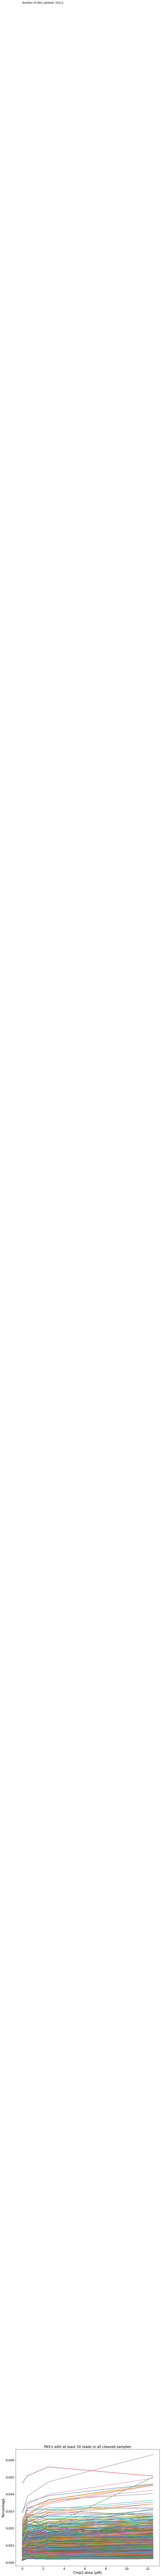

In [9]:
# Restricting plotting to only those found in all cleaved datasets with at least 30 reads

all_intersect = list(PAS_mincov30["SVLst_DMSO"].intersection(PAS_mincov30["SVLst_0p5uM"], PAS_mincov30["SVLst_2p5uM"], PAS_mincov30["SVLst_12p5uM"]))
print(all_intersect[:10])

PAS_mincov30_df = merged_PAS_percentage.set_index("PAS")
PAS_mincov30_df = PAS_mincov30_df.loc[all_intersect]
PAS_mincov30_df.columns = [0, 0.5, 2.5, 12.5]

plot_df = PAS_mincov30_df.T *100
print(plot_df)


f = plt.figure(figsize=(8, 6))
f.set_size_inches(18.5, 10.5, forward=True)

ax = plot_df.plot(figsize=(12, 10))
#type(ax)  # matplotlib.axes._subplots.AxesSubplot
ax.get_legend().remove()
ax.ticklabel_format(style='plain')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Cmp2 dose (μM)', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title("PAS's with at least 30 reads in all cleaved samples", fontsize=16)
plt.text(0, 0.15, "Number of PAS's plotted: " + str(len(plot_df.columns)), fontsize=12)

plt.savefig(parsed_SVLst_cleaved_output_dir + "PAS_percentages_mincov30shared.tiff")
